--- 1. BLS SEARCH ---
BLS Found: P=0.5000, T0=2054.4053
Guess P  : 0.50000 (True: 0.81)
Guess a  : 2.7   (True: 4.86)

--- 2. RUNNING 2-STAGE OPTIMIZATION ---
  > Stage 1: Fixing Geometry...
    Stage 1 P: 0.93993
  > Stage 2: Refining Fit...
Optimization Success: True
Recovered P  : 0.94313
Recovered a  : 4.21576

--- 4. RUNNING MCMC ---
Initializing walkers...
All walkers started in valid space. Starting Run.


100%|██████████| 3000/3000 [00:17<00:00, 170.80it/s]


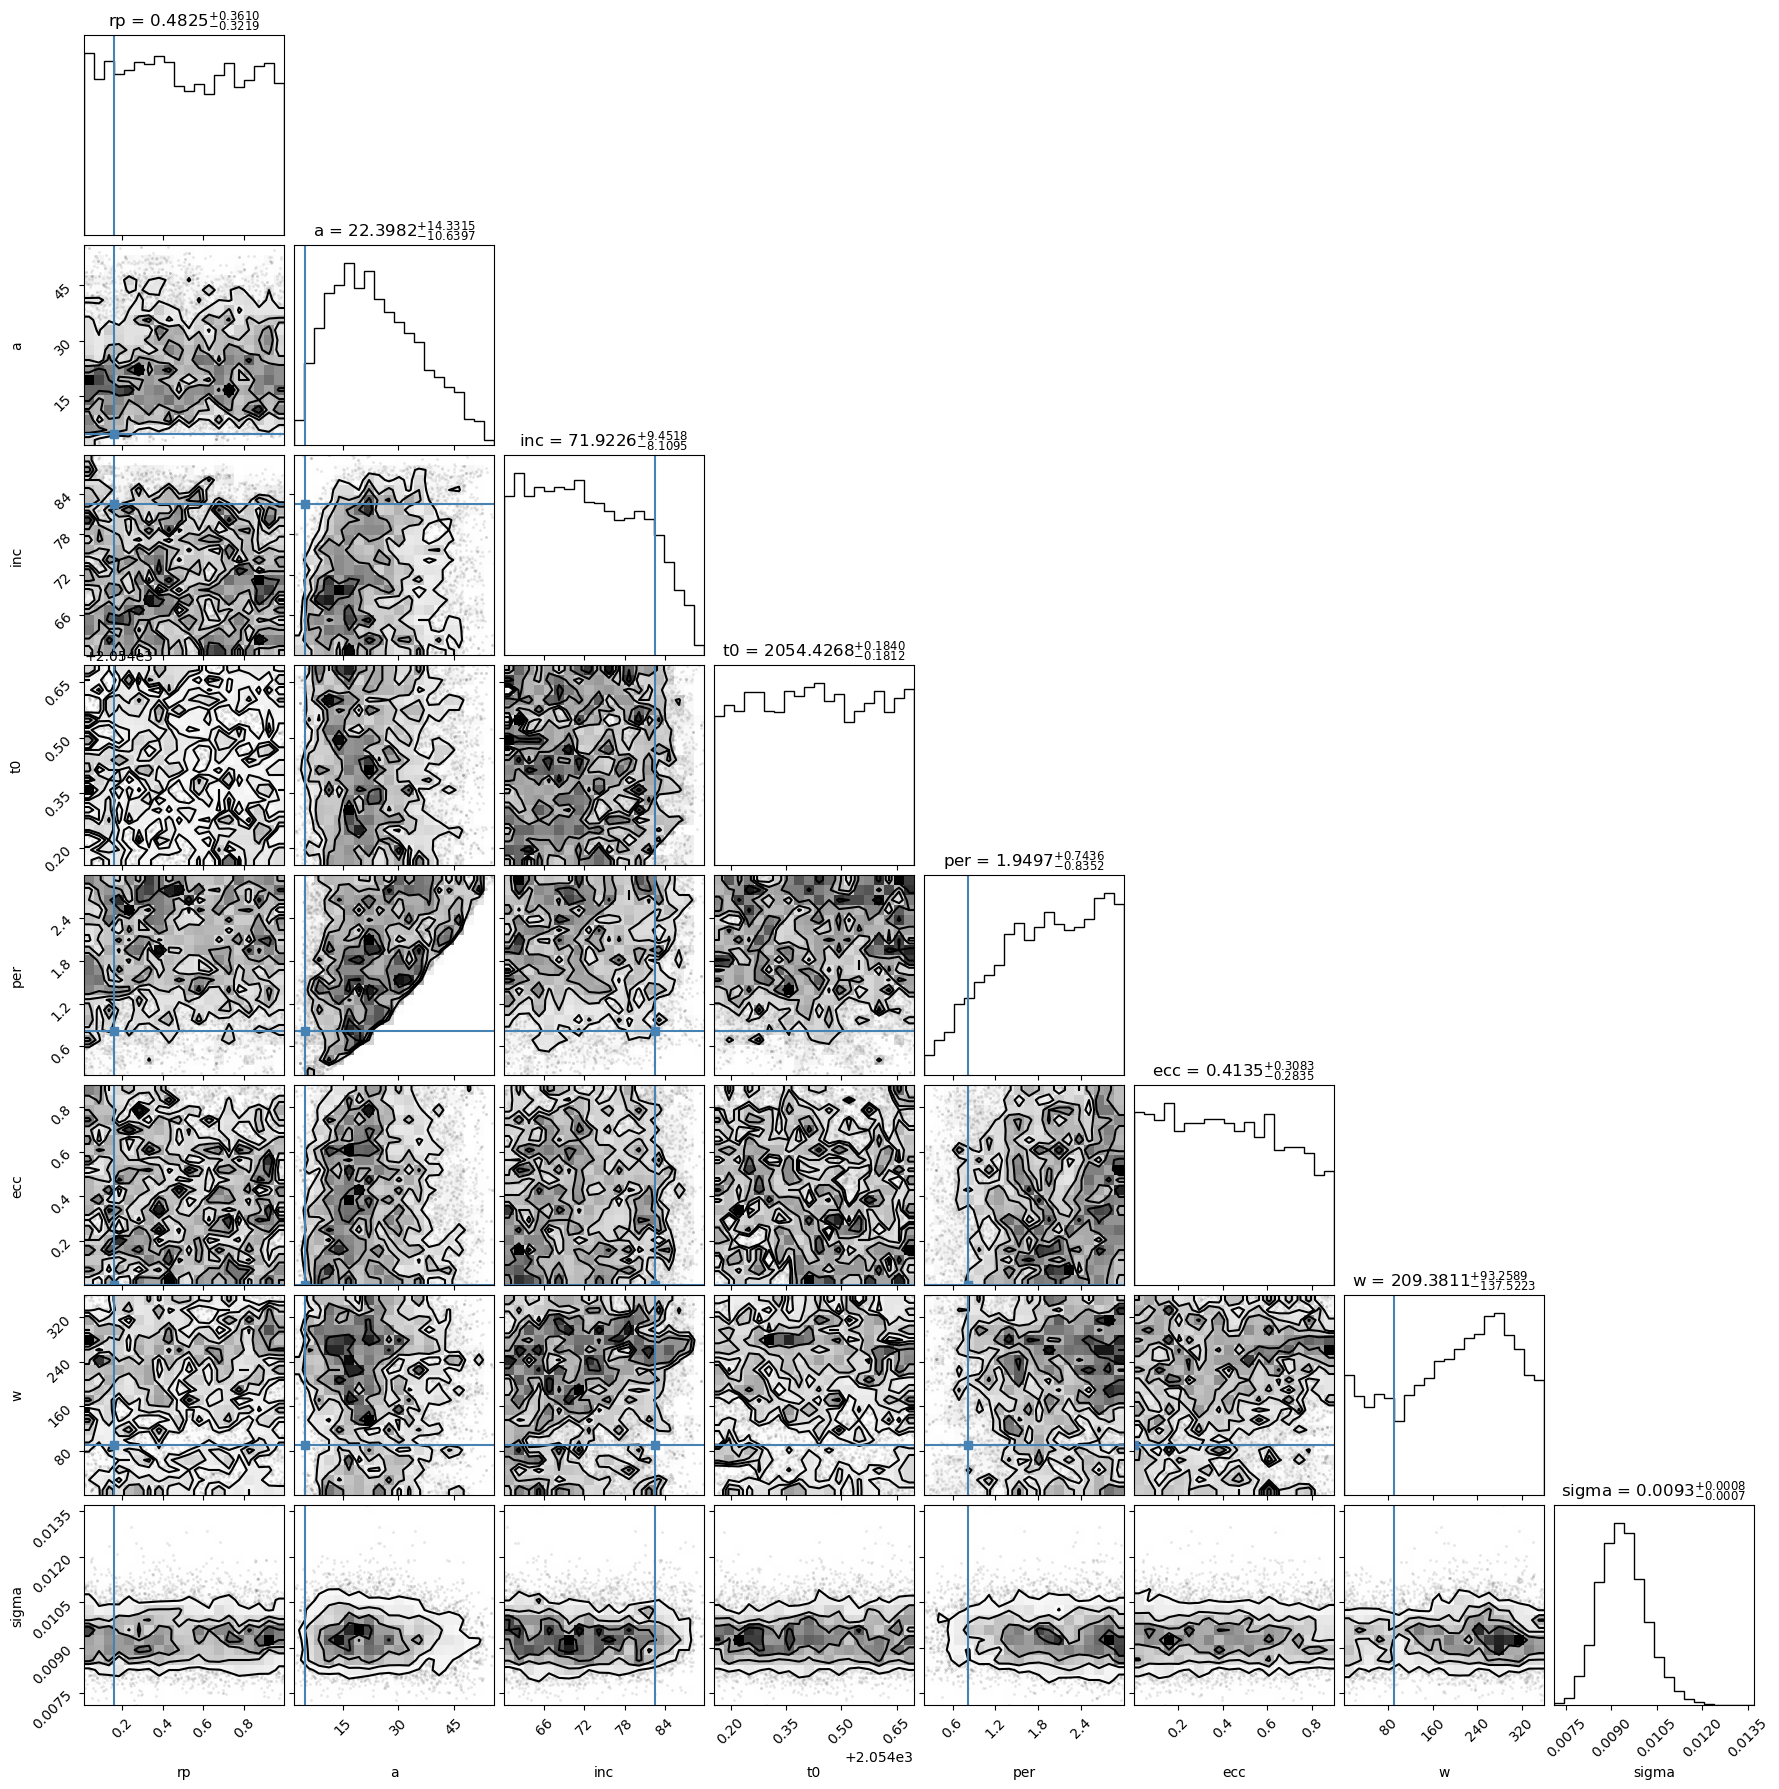

Final rp  : 0.49718
Final a  : 23.95042   
Final T0 : 2054.42774 
Final inc  : 72.50428   
Final P  : 1.90077 
Final ecc  : 0.42335 
Final w : 195.96638 


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import batman
import emcee
import corner
import pandas as pd
from scipy.optimize import minimize
from astropy.timeseries import BoxLeastSquares

#Give true parameters (paramters for Wasp-43)
true_params = {
    "rp":0.16 , "a": 4.86, "inc": 82.5, "t0": 0.0, 
    "per": 0.81, "ecc": 0, "w": 90.0, "u": [0.3, 0.2], "sigma": 3e-4
}

#Lightcurve
data = pd.read_csv('2232_01_TIC439444938_cleaned_lc.csv')
flux= data['flux_normalized'].values
t = data['time_btjd'].values
flux_err = data['flux_err'].values
cond1 = t > 2054.15
cond2 = t < 2054.7
t = t[cond1 & cond2] 
flux = flux[cond1 & cond2]
flux_err = flux_err[cond1 & cond2]

def batman_model(theta, time):
    rp, a, inc, t0, per, ecs, ess, _ = theta
    ecc = ecs**2 + ess**2
    w_deg = np.degrees(np.arctan2(ess, ecs))
    if w_deg < 0: w_deg += 360.0

    if ecc >= 1.0 or a <= 0: return np.ones_like(time)

    params = batman.TransitParams()
    params.t0 = t0; params.per = per; params.rp = rp; params.a = a; params.inc = inc
    params.ecc = ecc; params.w = w_deg; params.u = [0.3, 0.2]; params.limb_dark = "quadratic"
    
    m = batman.TransitModel(params, time)
    return m.light_curve(params)


#BLS Search
print("--- 1. BLS SEARCH ---")
model_bls = BoxLeastSquares(t, flux)
period_grid = np.linspace(0.5, 2.0, 5000)
periodogram = model_bls.power(period_grid, duration=0.1, objective="snr")

best_ix = np.argmax(periodogram.power)
bls_per = periodogram.period[best_ix]
bls_t0 = periodogram.transit_time[best_ix]
bls_depth = periodogram.depth[best_ix]
bls_rp = np.sqrt(bls_depth)
print(f"BLS Found: P={bls_per:.4f}, T0={bls_t0:.4f}")

# guess for a derived from the value of P
def estimate_semi_major_axis(period_days, mass_solar=1.0, radius_solar=1.0):
    # Constants
    G = 6.67430e-11 
    M_sun = 1.989e30 
    R_sun = 6.957e8 
    
    # Calculate Density of the star (assuming Sun-like by default)
    rho = (mass_solar * M_sun) / ((4./3.) * np.pi * (radius_solar * R_sun)**3)
    per_sec = period_days * 86400.0
    a_over_r = ((G * rho * per_sec**2) / (3 * np.pi))**(1.0/3.0)
    
    return a_over_r

#Intial Guesses
guess_a = estimate_semi_major_axis(bls_per)
guess_inc = 89.0
guess_per = bls_per 
guess_t0 = bls_t0   
guess_ecs = 0.0
guess_ess = 0.0

initial_guess_geo = np.array([
    bls_rp, guess_a, guess_inc, guess_t0, guess_per, guess_ecs, guess_ess
])

print(f"Guess P  : {guess_per:.5f} (True: {true_params['per']})")
print(f"Guess a  : {guess_a:.1f}   (True: {true_params['a']})")

# Optimize
print("\n--- 2. RUNNING 2-STAGE OPTIMIZATION ---")

rho_obs_mean = (true_params["a"]**3) / (true_params["per"]**2)
rho_obs_sigma = 0.1 * rho_obs_mean

def ln_prior(theta):
    rp, a, inc, t0, per, ecs, ess, ln_sigma = theta
    if not (0.01 < rp < 1.0): return -np.inf
    if not (1.0 < a < 100.0): return -np.inf
    if not (60.0 < inc < 90.0): return -np.inf
    if not (t.min() < t0 < t.max()): return -np.inf
    if not (0.2 < per < 3.0): return -np.inf
    if not (-15.0 < ln_sigma < 1.0): return -np.inf # Keep sigma bounded
    
    ecc_sq = ecs**2 + ess**2
    if ecc_sq >= 0.9: return -np.inf
    
    # 0-90 degree constraint on w
    w_deg = np.degrees(np.arctan2(ess, ecs))
    if w_deg < 0: w_deg += 360.0

    rho_proxy = (a**3) / (per**2)
    if not (10.0 < rho_proxy < 20000.0):
        return -np.inf

    return 0.0

#Posterior
def neg_ln_posterior_stage1(theta_geo, time, flux, flux_err):
    # Lock sigma to the median error
    fixed_ln_sigma = np.log(np.median(flux_err)) 
    theta_full = np.concatenate([theta_geo, [fixed_ln_sigma]])
    
    lp = ln_prior(theta_full)
    if not np.isfinite(lp): return 1e25
    
    try:
        model = batman_model(theta_full, time)
    except:
        return 1e25
        
    resid = flux - model
    chisq = np.sum((resid / flux_err) ** 2)
    return chisq - lp 

#Free Sigma
def neg_ln_posterior_stage2(theta_full, time, flux, flux_err):
    # Now we fit everything, including sigma
    lp = ln_prior(theta_full)
    if not np.isfinite(lp): return 1e25
    
    rp, a, inc, t0, per, ecs, ess, ln_sigma = theta_full
    sigma_jitter = np.exp(ln_sigma)
    sigma_total_sq = flux_err**2 + sigma_jitter**2
    
    try:
        model = batman_model(theta_full, time)
    except:
        return 1e25

    resid = flux - model
    ln_like = -0.5 * np.sum( (resid**2 / sigma_total_sq) + np.log(2.0 * np.pi * sigma_total_sq) )
    return -(lp + ln_like)

# RUN STAGE 1 (Robust Geometry)
print("  > Stage 1: Fixing Geometry...")
soln1 = minimize(neg_ln_posterior_stage1, initial_guess_geo,
                 args=(t, flux, flux_err), method='Nelder-Mead')
print(f"    Stage 1 P: {soln1.x[4]:.5f}")

# RUN STAGE 2 (Refine Eccentricity & Sigma)
# We take the result from Stage 1, append a guess for sigma, and optimize again.
initial_guess_stage2 = np.concatenate([soln1.x, [np.log(1e-4)]])

print("  > Stage 2: Refining Fit...")
soln2 = minimize(neg_ln_posterior_stage2, initial_guess_stage2,
                 args=(t, flux, flux_err), method='Nelder-Mead')

print(f"Optimization Success: {soln2.success}")
print(f"Recovered P  : {soln2.x[4]:.5f}")
print(f"Recovered a  : {soln2.x[1]:.5f}")

#RUNNING MCMC (ROBUST INITIALIZATION)
print("\n--- 4. RUNNING MCMC ---")

# 1. Define the Strict MCMC Functions
def ln_likelihood_mcmc(theta, time, flux, flux_err):
    rp, a, inc, t0, per, ecs, ess, ln_sigma = theta
    
    # Check for NaNs in parameters (just in case)
    if np.any(np.isnan(theta)): return -np.inf

    sigma_jitter = np.exp(ln_sigma)
    sigma_total_sq = flux_err**2 + sigma_jitter**2
    
    ecc = ecs**2 + ess**2
    w_deg = np.degrees(np.arctan2(ess, ecs))
    if w_deg < 0: w_deg += 360.0
    
    try:
        params = batman.TransitParams()
        params.t0 = t0; params.per = per; params.rp = rp; params.a = a; params.inc = inc
        params.ecc = ecc; params.w = w_deg; params.u = [0.3, 0.2]; params.limb_dark = "quadratic"
        m = batman.TransitModel(params, time)
        model = m.light_curve(params)
    except:
        return -np.inf 

    resid = flux - model
    # Check for NaNs in the model output
    if np.any(np.isnan(model)): return -np.inf

    ln_like = -0.5 * np.sum((resid**2 / sigma_total_sq) + np.log(2.0 * np.pi * sigma_total_sq))
    return ln_like

def ln_posterior_mcmc(theta, time, flux, flux_err):
    lp = ln_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = ln_likelihood_mcmc(theta, time, flux, flux_err)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll

ndim = 8
nwalkers = 50

# 2. Determine the Center Point
# Check if the optimizer output (soln2.x) is actually valid. 
# If the optimizer pushed parameters into a forbidden zone (like rho too high), 
# we revert to the stage 1 guess.
center_point = soln2.x
if not np.isfinite(ln_posterior_mcmc(center_point, t, flux, flux_err)):
    print("Warning: Optimizer result is invalid. Reverting to geometric guess.")
    # Pad the stage 1 guess with a sigma estimate
    center_point = np.concatenate([soln1.x, [np.log(np.median(flux_err))]])

# 3. Initialize Walkers with "Respawn" Logic
pos = center_point + 1e-4 * np.random.randn(nwalkers, ndim)

print("Initializing walkers...")
for i in range(nwalkers):
    # While the current walker 'i' is in a bad spot (-inf)...
    while not np.isfinite(ln_posterior_mcmc(pos[i], t, flux, flux_err)):
        # ...pick a new random spot closer to the center
        pos[i] = center_point + 1e-4 * np.random.randn(ndim)

print("All walkers started in valid space. Starting Run.")

# 4. Run MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior_mcmc, args=(t, flux, flux_err))
sampler.run_mcmc(pos, 3000, progress=True)

# Results
tau = sampler.get_chain().shape[0]
discard = int(tau * 0.3)
flat_samples = sampler.get_chain(discard=discard, thin=15, flat=True)

rp = flat_samples[:, 0]
a = flat_samples[:, 1]
inc = flat_samples[:, 2]
t0 = flat_samples[:, 3]
per = flat_samples[:, 4]
ecc = flat_samples[:, 5]**2 + flat_samples[:, 6]**2
w = np.degrees(np.arctan2(flat_samples[:, 6], flat_samples[:, 5]))
w[w<0] += 360
sigma = np.exp(flat_samples[:, 7])

samples_phys = np.vstack([rp, a, inc, t0, per, ecc, w, sigma]).T
labels = ["rp", "a", "inc", "t0", "per", "ecc", "w", "sigma"]
truths = [true_params["rp"], true_params["a"], true_params["inc"], true_params["t0"],
          true_params["per"], true_params["ecc"], true_params["w"], true_params["sigma"]]

corner.corner(samples_phys, labels=labels, truths=truths, show_titles=True, title_fmt=".4f")
plt.show()

print(f"Final rp  : {np.mean(rp):.5f}")
print(f"Final a  : {np.mean(a):.5f}   ")
print(f"Final T0 : {np.mean(t0):.5f} ")
print(f"Final inc  : {np.mean(inc):.5f}   ")
print(f"Final P  : {np.mean(per):.5f} ")
print(f"Final ecc  : {np.mean(ecc):.5f} ")
print(f"Final w : {np.mean(w):.5f} ")